In this project we will recreate the analysis made by Mirabel et.al in 'Accretion instabilities and jet formation in GRS 1915+105'. This object emits a X-ray oscillating flux and the ejection of plasma clouds with very high energy partciles. data were collected by VLA on May 15 1997. The emission observed is consisten with a synchrotron emission from an adiabatically expanding blob, i.e., can be described with a van deer Laan model.

One of the easiest models to study the evolution of an expanding glob was proposed by van der laan, it consider that
$$
    N_0 \propto R^{-(2+p)}~~~~~~~~~~B\propto R^{-2}
$$

In this code we will calculate Brightness temperature, magnetic field, and the parameters of the power law describing the relativistic electron population. We assume a constant expansion of $0.2c$

# 1. Introduction.

Some usefull libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

#gamma function
from scipy import special, optimize

#Fitting the spectrum
from scipy.optimize import curve_fit

#Packages to make an interactive plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

#Matplotlip colors and grid
from matplotlib.cm import rainbow
import matplotlib.gridspec as grd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

#Packages for using tables and units in astropy
from astropy.table import QTable
import astropy.units as u
from astropy.io import ascii

#Astropy module to handle units
from astropy import units as u
from astropy.units import Quantity
from astropy import constants as const

#Importing the constant that will be needed
from astropy.constants import c, k_B,m_e,e

#Packages to make an interactive plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

#Confidence interval
import scipy.stats as st 

Some functions that will be needed. Power law for the expanding radius and the expresions for magnetic field an dnumber density as a function of r.

In [2]:
def PLradius(time, speed, r0, a):
    """
    PLradius gives the radius after a given t of an expanding object with initial radius and a given speed driven by a power law

    Parameters
    :t: time of the expansion
    :v: speed of the expansion
    :r0: initial radius
    :a: parameter of the power law

    Output
    :r: radius at the end of the expansion
    """
    
    r=r0 + (speed*(time**a))
    return r

def Br(r, B0, r0):
    """
    Br returns the value of the magnetic field at a given r known the value B0 at r0

    Parameters
    :r: radius at which the magnetic field will be calculated
    :B0: magnetic field at a starting radius
    :r0: radius at starting

    Output
    :Br: Magentic field at a radius r of the object
    """
    
    Br=B0*((r/r0)**(-2))
    return Br

def Nr(r, N0, r0, p):
    """
    Nr returns the value of the electron density at a given r known the value N0 at r0

    Parameters
    :r: radius at which the magnetic field will be calculated
    :N0: electron density at a starting radius
    :r0: radius at starting
    :p: exponent of the power law

    Output
    :Nr: electron density at a radius r of the object
    """
    
    Nr=N0*((r/r0)**(-(2+p)))
    return Nr

Let's read the data points and save it on a python table.

In [3]:
#Defining variables to save time and flux values of each point
time=[]
flux=[]
#Saving the table in a list where each element is a 2D array with the coordinates of the points
with open('Data/2cm.csv', 'r') as f:
    l = [[float(num.replace(',', '.')) for num in line.split()] for line in f]
#Saving time and flux of each point individually
for value in l:
    time.append(value[0])
    flux.append(value[1])
#Making a table out of the previus values
cm2= QTable([time*u.hour,flux*u.mJy],names=['UT time (hours)', 'Flux density (mJy)'], meta={'name': 'Light curves of GRS 1915+105 for May 15, 1997 obtained with the VLA at 2 cm'})

#Repeat for 3.6cm wavelenght
time=[] #Cleaning the list
flux=[]
with open('Data/3.6cm.csv', 'r') as f:
    l = [[float(num.replace(',', '.')) for num in line.split()] for line in f]
for value in l:
    time.append(value[0])
    flux.append(value[1])
cm3= QTable([time*u.hour,flux*u.mJy],names=['UT time (hours)', 'Flux density (mJy)'], meta={'name': 'Light curves of GRS 1915+105 for May 15, 1997 obtained with the VLA at 3.6 cm'})

#Repeat for 6cm wavelength
time=[]
flux=[]
with open('Data/6cm.csv', 'r') as f:
    l = [[float(num.replace(',', '.')) for num in line.split()] for line in f]
for value in l:
    time.append(value[0])
    flux.append(value[1])
cm6= QTable([time*u.hour,flux*u.mJy],names=['UT time (hours)', 'Flux density (mJy)'], meta={'name': 'Light curves of GRS 1915+105 for May 15, 1997 obtained with the VLA at 6 cm'})

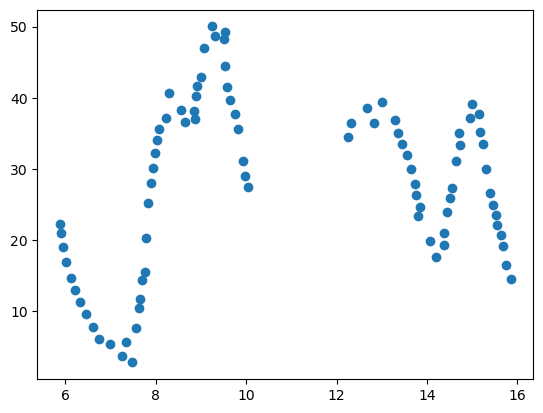

In [4]:
plt.scatter(cm6['UT time (hours)'],cm6['Flux density (mJy)'])

# 2. Calculus.

We want to make a least squares fit to our data, the expression to fit will be 
It is whown in the bibliografy that the intensity is
$$
    F_\nu = \Omega I_\nu = \frac{\pi R^2}{D^2}I_\nu,
$$
with
$$
    I_\nu = S(\nu_1) J\left( \frac{\nu}{\nu_1},p \right),
$$
is the frequency at the transition from thick to thin, where $S(\nu_1)= \frac{c_5}{c_6}B^{-1/2} \left( \frac{\nu_1}{2c_1} \right)^{5/2}$ is the source function at $\nu_1$ and $J(z, p)=z^{\frac{5}{2}}\left[1-\exp \left(-z^{-\frac{p+4}{2}}\right)\right]$. And $\nu_1$
$$
    \nu_1=2c_1(sc_6)^{\frac{2}{p+4}}N_0^{\frac{2}{p+4}}B^{\frac{p+2}{p+4}}~~Hz,
$$
where $c_6$, $c_5$ and $c_1$ are constants given by (Pacholcyzk)
$$
c_1=\frac{3 e}{4 \pi m^3 c^5}
$$

$$
c_5=\frac{\sqrt{3}}{16 \pi} \frac{e^3}{m c^2}\left(\frac{\gamma+7 / 3}{\gamma+1}\right) \Gamma\left(\frac{3 \gamma-1}{12}\right) \Gamma\left(\frac{3 \gamma+7}{12}\right)
$$

$$
c_6=\frac{\sqrt{3} \pi}{72} e m^5 c^{10}\left(\gamma+\frac{10}{3}\right) \Gamma\left(\frac{3 \gamma+2}{12}\right) \Gamma\left(\frac{3 \gamma+10}{12}\right)
$$

In [5]:
#First of all defininf Pacholcyzk's constants
c1=(const.e.esu*3/(4*np.pi*const.m_e**3*c**5)).cgs.value

def Pacholcyzk5(p):
    """
    Pacholcyzk5 returns the value of the Pacholcyzk c5 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c5: Value of the constant
    """
    c5=3**0.5/(16*np.pi)*(const.e.esu**3/(const.m_e*const.c**2))*(p+7/3)/(p+1)*scipy.special.gamma((3*p-1)/12)*scipy.special.gamma((3*p+7)/12)
    #return only the value in SI units to make possible a fit
    return c5.cgs.value
    
def Pacholcyzk6(p):
    """
    Pacholcyzk6 returns the value of the Pacholcyzk c6 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c6: Value of the constant
    """
    c6=np.pi*3**0.5/(72)*const.e.esu*const.m_e**5*const.c**10*(p+10/3)*scipy.special.gamma((3*p+2)/12)*scipy.special.gamma((3*p+10)/12)
    return c6.cgs.value
    
def calculatev1(s, p, N_0, B):
    """
    calculatev1 returns the value of the frequency at which the optical depth is 1 for a population of electron
    driven by a power law

    Parameters
    :s: Thickness of the source
    :p: Exponent of the power law of electron population
    :N_0: Constant multiplicative factor in the power law
    :B: Value of the magnetic field

    Output
    :v1: Frequency at which the optical depth is 1
    """

    #Computing the ressult, and giving it in Hz, since we do not know Pacholcyzk constannt units but we made
    #everything in cgs
    v1=(2*c1*(s*Pacholcyzk6(p))**(2/(p+4))*N_0**(2/(p+4))*B**((p+2)/(p+4)))
    return v1

Now let's deffine the functions needed for the intensity. The first box is one way to compute the source functions, the second box is another, both from Pacholcyzk.

In [6]:
#Defining absorption and emission coefficients
def SynchrotronEmissionCoeff(p, B, N0, frequency):
    """
    Returns the emission coefficient for a synchrotron emisison of a population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the emission coefficient want to be calculated

    Output
    :EmissionCoeff: Emission coefficient value
    """

    EmissionCoeff=Pacholcyzk5(p)*N0*B**((p+1)/2)*(frequency/(2*c1))**((1-p)/2)
    return EmissionCoeff

def SynchrotronAbsorptionCoeff(p, B, N0, frequency):
    """
    Returns the absorption coefficient for a synchrotron population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the absorption coefficient want to be calculated

    Output
    :AbsorptionCoeff: absorption coefficient value
    """

    AbsorptionCoeff=Pacholcyzk6(p)*N0*B**((p+2)/2)*(frequency/(2*c1))**(-(p+4)/2)
    return AbsorptionCoeff

def SourceFuncSynch(p, B, N0, frequency):
    """
    returns the value of the source function for a given frequency

    Parameters
    :p: Exponent of the power law of electron population
    :B: Value of the magnetic field
    :N0: Constant of the power law
    :Ne: Thermal electron number density
    :Te: Temperature of the electrons
    :frequency: frequency at which the source function want to be calculated
    
    Output
    :S: Value of the source function at the given frequency
    """

    S=SynchrotronEmissionCoeff(p, B, N0, frequency)/(SynchrotronAbsorptionCoeff(p, B, N0, frequency))
    return S

In [7]:
def SourceFunc(p, B, frequency):
    """
    Source returns the value of the source function for a given frequency

    Parameters
    :p: Exponent of the power law of electron population
    :B: Value of the magnetic field
    :v: frequency at which the source function want to be calculated
    
    Output
    :S: Value of the source function at the given frequency
    """
    
    S=(Pacholcyzk5(p)/Pacholcyzk6(p)*B**(-1/2)*(frequency/(2*c1))**(5/2))
    return S

def JFunc(z, p):
    """
    Returns the value of the J function defined on the calculation of the intensity for a population
    of relativistic electrons driven by a power law of exponent p

    Paramenters
    :z: ratio of the frequency of interest and the frequency v1
    :p: Exponent of the power law

    Output
    :J:
    """

    J=z**(5/2)*(1-np.exp(-z**(-(p+4)/2)))
    return J

We can now compute the intensity and the flux.

In [8]:
def SpecInt(frequency, p, B, s, N0):
    """
    SpecInt returns the specific intensity of a population of relativistic electrons driven by a power law at a given
    frequency

    Paramenters
    :v: frequency at which the specific intensity is computed
    :p: exponent of the power law
    :B: Magnetic field
    :s: Thickness of the source
    :N0: Constant of the power law

    Output
    :I: specific intensity at the given frequency
    """
    
    v1=calculatev1(s, p, N0, B)
    #First line is one expression for source
    #I= SourceFunc(p, B, frequency)*JFunc(frequency/v1, p)
    #Next line can be used to check the other deffinition of Synchrotron source expression
    I=SourceFuncSynch(p, B, N0, frequency)*(1-np.exp(-SynchrotronAbsorptionCoeff(p, B, N0, frequency)*s))
    return I

def solidangle(radius, distance):
    """
    solidangle gives the solid angle of a source at distance d and size r in the small angle approximation.If units are 
    desired at the output, they must be inserted in the parameters with unit module

    Parameters
    :radius: radius of the source
    :distance: distance from Earth to source

    Outputs
    :omega: solid angle of the source
    """
    #Applying the expresion for the solid angle in the small angle approximation
    omega= np.pi * (radius**2)/(distance**2)
    return omega

In [9]:

def FluxatT(time, frequency, p, B0, N0, distance, r0, speed, a, offset=0):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :time: Time at wich the flux is calculated
    :frequency: frequency at which the specific intensity is computed
    :p: exponent of the power law describing electron population
    :B0: Magnetic field when radius is r0
    :N0: Constant of the power law
    :distance: Distance to the source
    :r0: reference radius of the source
    :speed: speed of the expansion
    :a: exponent of the power law describing expansion
    :offset: Optional parameter to make a fit with the offset of the time
    
    Output
    :F: Flux of the source
    """
    #Computing the radius at a given time
    r=PLradius(time- offset, speed, r0, a)
    #Computing number density and magentic field for the corresponding r
    B=Br(r, B0, r0)
    N= Nr(r, N0, r0, p)
    
    F=solidangle(r, distance)*SpecInt(frequency, p, B, r, N)
    return F*1e23 #In order to get from cgs to Jy

We defined our function with frequencies, but sometimes data is given in wavelenght or viceversa, here we make some functions to change between them.

In [10]:
def freqtowavelenght(frequency):
    """
    Transforms from frequency to wavelenght

    Parameters
    :frequency: Input frequency

    Output
    :wavelenght:
    """
    frequency=frequency.to(u.Hz)
    return (const.c/frequency).decompose()

def wavelenghttofreq(wavelenght):
    """
    Transforms from wavelenght to frequency

    Parameters
    :wavelenght: Input wavelenght

    Output
    :frequency:
    """
    wavelenght=wavelenght.to(u.m)
    return (const.c/wavelenght).decompose()

Finally we can make a regression of the data to the flux function and get the values of $p$, $B_0$, $r_0$ and $N_0$. But first we need to separate the data in regions since

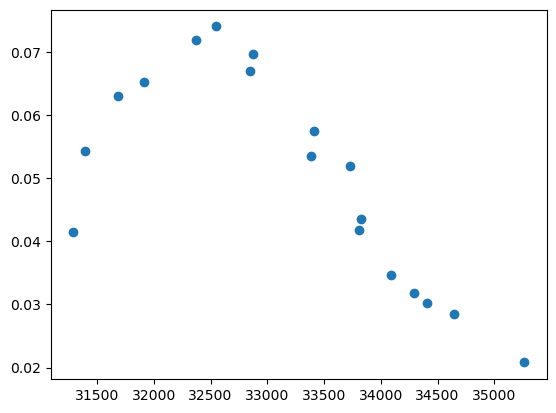

In [11]:
#Data for the 2cm line and the first peak
x2_1=cm2['UT time (hours)'][72:98].to(u.s).value
y2_1=cm2['Flux density (mJy)'][72:98].to(u.Jy).value
#Second peak
x2_2=cm2['UT time (hours)'][30:48].to(u.s).value
y2_2=cm2['Flux density (mJy)'][30:48].to(u.Jy).value

plt.scatter(x2_2,y2_2)

In order to have some initial parameters and check the code, we can search by hand some values that approxime the data curve. In the paper it is said that the size of the blob was measured to be $10^{13}$ after $900s$, so we can estimate that with a given speed near $0.2c$ this will lead to $\approx 10^{12}$ at $t=0$.

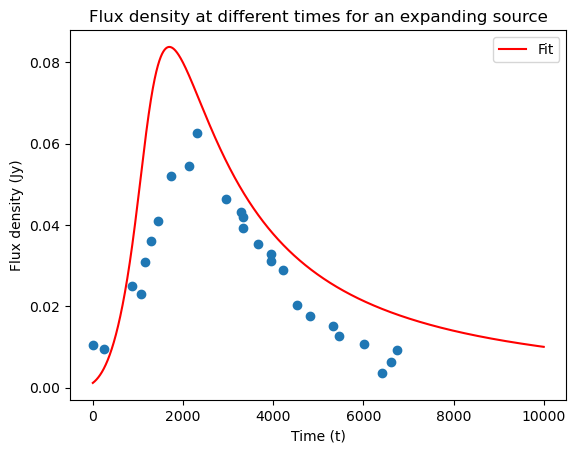

In [12]:
#Quantizing the time
t=(np.linspace(0, 10000.0, 100000)*u.s).value
#Assuming some input parameters


#input for cm2 and cm3
p=0.78
d=(11000*u.pc).to(u.cm).value  #Known distance to the binary
B0=( 50*u.G).value
r0= ((1e12)*u.cm).value #HIGH SENSITIVITY TO THIS PARAMETER LEFT AND RIGHT PEAK will be input, too small implies
                        # that the flux spectrum doesnt rise from 0 (has sense since it has expanded and not coming from 
                        #a point)
N0= (2e7*1/u.cm**3).value #UP OR DOWN PEAK FLUX
speed=(const.c*0.08).cgs.value #WIDTH OF THE SPECTRUM PEAK

#Computing the flux at r
F1= FluxatT(t, wavelenghttofreq(2*u.cm).cgs.value, p, B0, N0, d, r0,speed, 1)
x=x2_1
y=y2_1


"""
#Little travel following the negative value
p=0.3
nu= wavelenghttofreq(2*u.cm).cgs.value
SourceFunc(p, B0, 3e14)

(Pacholcyzk5(p)/Pacholcyzk6(p)) #Aqui esta lo que sale negativo

scipy.special.gamma((3*p-1)/12)
"""

#Plotting the results
l1="Fit"
plt.plot(t,F1,'r', label=l1)
plt.xlabel(f"Time (t)")
plt.ylabel(f'Flux density (Jy)')
plt.title('Flux density at different times for an expanding source')
plt.legend()
plt.scatter(x-1*min(x),y) #Substract the first time value in order to align the data with 0
plt.show()


And now we can procceed to fit the data with curve_fit astropy module. Testing the function with a single outburst.

In [13]:
#Frequency at wich we are observing the flux
nu=wavelenghttofreq(1*u.cm).to(u.Hz).value
#Select with wavelenght and peak we want to see
x=x2_1
y=y2_1
alpha= curve_fit(lambda time, pf, B0f, N0f, speedf: FluxatT(time, nu, pf, B0f, N0f, d, r0, 
                                                        speedf, 1.), x-1*min(x), y, (p,B0,N0,speed), maxfev=5000)
alpha

/tmp/ipykernel_42558/3936713244.py:46: RuntimeWarning: invalid value encountered in power
  v1=(2*c1*(s*Pacholcyzk6(p))**(2/(p+4))*N_0**(2/(p+4))*B**((p+2)/(p+4)))


(array([1.88751633e+00, 2.79597167e+00, 1.61772358e+04, 4.99390482e+08]),
 array([[ 2.86754243e-02, -2.26400623e-01, -2.24340744e+03,
         -8.98278184e+06],
        [-2.26400623e-01,  2.10091556e+00,  1.65306953e+04,
          9.00443764e+07],
        [-2.24340744e+03,  1.65306953e+04,  1.80492310e+08,
          6.36563762e+11],
        [-8.98278184e+06,  9.00443764e+07,  6.36563762e+11,
          4.07817464e+15]]))

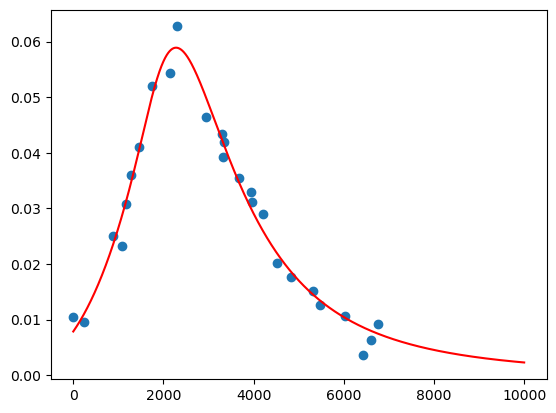

In [14]:
plt.scatter(x-1*min(x), y)
plt.plot(t, FluxatT(t,nu, alpha[0][0], alpha[0][1], alpha[0][2], d, r0, alpha[0][3]
                         , 1.), c='red')

plt.show()

In [15]:
print(f'Values: \n p= {alpha[0][0]} \n B0={alpha[0][1]*u.G} \n N0={alpha[0][2]*1/u.cm**3} \n speed={(alpha[0][3]*u.cm/u.s).si/(const.c)}c ')

Values: 
 p= 1.8875163250253748 
 B0=2.7959716651801436 G 
 N0=16177.235815757529 1 / cm3 
 speed=0.01665787343347428c 


A fast $\chi^2$ to test the fit

In [16]:
def calc_reduced_chi_square(fit, x, y, N, n_free):
    '''
    fit (array) values for the fit
    x,y (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y))**2)

In [17]:
calc_reduced_chi_square(FluxatT(x-min(x),nu, alpha[0][0], alpha[0][1], alpha[0][2], d, r0, alpha[0][3]
                         , 1.), x-min(x), y, x.size, 4)

6.98538127361004e-06

To make it easier, lets make a function that given a set of peaks of a spectrum, with it's times gives the fit matrix

In [18]:
def VanDerLaanFit(time, FluxDens, peaks, p_aprox, B0_aprox, offset_aprox, N0_aprox, speed_aprox, frequency, distance, r0, a):
    """
    Parameters (Everything in cgs )
    Data parameters
    :time: Time values of the full data for a given frequency 
    :FluxDens: Flux density values for the ful data at a given frequency
    :peaks: List of arrays range=(a_1, a_2, ...) where a[0] is the data point number of start and a[1] the end 

    Fit parameters
    :p_aprox: Aproximate value for the exponent of the electron power law
    :B0_aprox: Aproximate value for the initial magnetic field value
    :offset_aprox: Aproximate value for the time offset
    :N0_aprox: Aproximate value for the starting number density of electrons
    :speed_aprox: Aproximate value for the expansion speed

    Fixed parameters
    :frequency: Frequency at which the spectrum is measured
    :distance: Distance to the source
    :r0: Initial radius of the object
    :a: Exponent of the power law driving the expansion (1 is linear)

    Output
    :VanDerLaanFit: Array containing each coefficient matrix of each fit
    """
    VanDerLaanFit=[]
    #Repeat the code for each peak
    mintime= min(time)
    for peak in peaks:
        #Getting the time at flux for the points in the peak
        peak_t=time[peak[0]:peak[1]]
        #Choose the flux of the points in the time interval
        peak_f= FluxDens[peak[0] : peak[1]]
        
        #Some code to plot the results
        timelin= np.linspace(peak_t[0], peak_t[-1],100)

        #Normalicing the time
        peak_t=peak_t - 1*min(peak_t)
        #Starting the code for the fit
        alpha= curve_fit(lambda time, p, B0, N0, speed, offset: FluxatT(time, frequency, p, B0, N0, distance, r0, speed, a, offset), 
                         peak_t, peak_f, (p_aprox, B0_aprox, N0_aprox, speed_aprox, offset_aprox), maxfev=5000)
        #Im not using the covariance matrix, so use alpha[0]
        VanDerLaanFit.append(alpha[0])

        #Plotting time in minutes
        plt.plot(timelin/60. , FluxatT(timelin - min(timelin) , frequency, alpha[0][0], alpha[0][1], alpha[0][2], distance, r0, alpha[0][3]
                         , 1., offset= alpha[0][4] ), c='orange')

    return VanDerLaanFit

For simplicity lets make a quick interactive function to find the ranges.

In [19]:
def SearchPeaks(data_x, data_y, range_start, range_end):
    plt.scatter(data_x[range_start:range_end],data_y[range_start:range_end])

In [20]:
data_x=cm3['UT time (hours)'].to(u.s).value
data_y=cm3['Flux density (mJy)'].to(u.Jy).value
interact(SearchPeaks, data_x=fixed(data_x), data_y= fixed(data_y),
        range_start=widget.IntSlider(min=0, max= data_x.size, step=1), 
         range_end=widget.IntSlider(min=0, max= data_x.size, step=1))

interactive(children=(IntSlider(value=0, description='range_start', max=137), IntSlider(value=0, description='…

<function __main__.SearchPeaks(data_x, data_y, range_start, range_end)>

/tmp/ipykernel_42558/3936713244.py:46: RuntimeWarning: invalid value encountered in power
  v1=(2*c1*(s*Pacholcyzk6(p))**(2/(p+4))*N_0**(2/(p+4))*B**((p+2)/(p+4)))
/tmp/ipykernel_42558/789289804.py:16: RuntimeWarning: invalid value encountered in power
  EmissionCoeff=Pacholcyzk5(p)*N0*B**((p+1)/2)*(frequency/(2*c1))**((1-p)/2)
/tmp/ipykernel_42558/789289804.py:33: RuntimeWarning: invalid value encountered in power
  AbsorptionCoeff=Pacholcyzk6(p)*N0*B**((p+2)/2)*(frequency/(2*c1))**(-(p+4)/2)
/tmp/ipykernel_42558/2881901038.py:48: RuntimeWarning: invalid value encountered in power
  Nr=N0*((r/r0)**(-(2+p)))
/tmp/ipykernel_42558/1912815321.py:21: RuntimeWarning: overflow encountered in exp
  I=SourceFuncSynch(p, B, N0, frequency)*(1-np.exp(-SynchrotronAbsorptionCoeff(p, B, N0, frequency)*s))


[array([ 1.05175978e+00,  2.32950698e+01,  7.27391198e+06,  1.88761299e+09,
        -2.93372439e+02]),
 array([ 3.29225784e+00,  4.69330395e-01,  1.48768354e+02,  4.98981675e+08,
        -3.14816365e+03]),
 array([ 1.88750767e+00,  2.38841910e+00,  1.19695450e+05,  8.66755099e+08,
        -8.48695480e+02])]

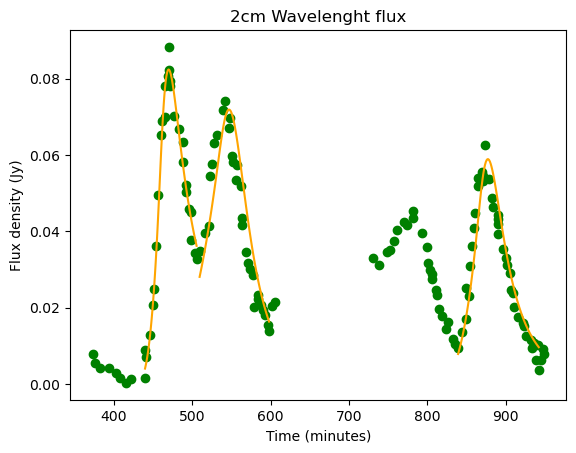

In [21]:
time=cm2['UT time (hours)'].to(u.s).value
FluxDens= cm2['Flux density (mJy)'].to(u.Jy).value
peaks= [[5,27], [27,53], [72,98]]
plt.scatter(time/60 , FluxDens, c='green')

frequency= wavelenghttofreq(2*u.cm).to(u.Hz).value
cm2_fit=VanDerLaanFit(time, FluxDens, peaks, p, B0, 0, N0, speed, frequency, d, r0, 1.) 

plt.xlabel(f"Time (minutes)")
plt.ylabel(f'Flux density (Jy)')
plt.title('2cm Wavelenght flux')
cm2_fit

/tmp/ipykernel_42558/3936713244.py:46: RuntimeWarning: invalid value encountered in power
  v1=(2*c1*(s*Pacholcyzk6(p))**(2/(p+4))*N_0**(2/(p+4))*B**((p+2)/(p+4)))
/tmp/ipykernel_42558/789289804.py:16: RuntimeWarning: invalid value encountered in power
  EmissionCoeff=Pacholcyzk5(p)*N0*B**((p+1)/2)*(frequency/(2*c1))**((1-p)/2)
/tmp/ipykernel_42558/789289804.py:33: RuntimeWarning: invalid value encountered in power
  AbsorptionCoeff=Pacholcyzk6(p)*N0*B**((p+2)/2)*(frequency/(2*c1))**(-(p+4)/2)
/tmp/ipykernel_42558/2881901038.py:48: RuntimeWarning: invalid value encountered in power
  Nr=N0*((r/r0)**(-(2+p)))


[array([ 9.59149904e-01,  3.96453161e+01,  1.50037451e+07,  2.32747527e+09,
        -5.53708742e+02]),
 array([ 3.63021724e+00,  7.17535820e-01,  1.62120555e+02,  6.62973537e+08,
        -6.02554013e+03]),
 array([ 1.93188786e+00,  4.57698624e+00,  2.11330855e+05,  1.18278098e+09,
        -2.44757649e+03])]

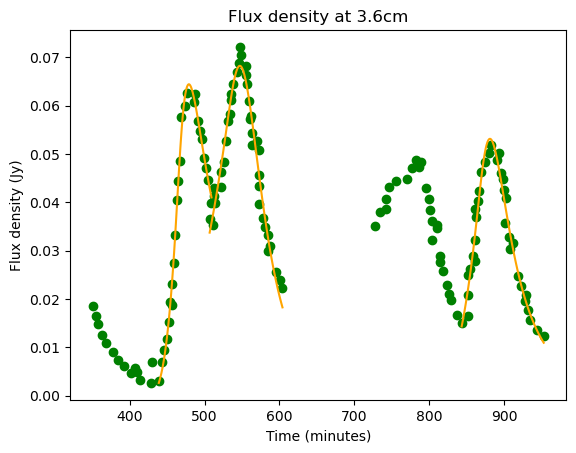

In [22]:
time=cm3['UT time (hours)'].to(u.s).value
FluxDens= cm3['Flux density (mJy)'].to(u.Jy).value
peaks= [[14,39], [39,78], [103, 137]] 
plt.scatter(time/60 , FluxDens, c='green')

plt.xlabel(f"Time (minutes)")
plt.ylabel(f'Flux density (Jy)')
plt.title('Flux density at 3.6cm')

frequency= wavelenghttofreq(3.6*u.cm).to(u.Hz).value
cm3_fit=VanDerLaanFit(time, FluxDens, peaks, p, B0, 0, N0, speed, frequency, d, r0, 1.)
cm3_fit

/tmp/ipykernel_42558/3936713244.py:46: RuntimeWarning: invalid value encountered in power
  v1=(2*c1*(s*Pacholcyzk6(p))**(2/(p+4))*N_0**(2/(p+4))*B**((p+2)/(p+4)))
/tmp/ipykernel_42558/789289804.py:16: RuntimeWarning: invalid value encountered in power
  EmissionCoeff=Pacholcyzk5(p)*N0*B**((p+1)/2)*(frequency/(2*c1))**((1-p)/2)
/tmp/ipykernel_42558/789289804.py:33: RuntimeWarning: invalid value encountered in power
  AbsorptionCoeff=Pacholcyzk6(p)*N0*B**((p+2)/2)*(frequency/(2*c1))**(-(p+4)/2)
/tmp/ipykernel_42558/2881901038.py:48: RuntimeWarning: invalid value encountered in power
  Nr=N0*((r/r0)**(-(2+p)))
/tmp/ipykernel_42558/1912815321.py:21: RuntimeWarning: overflow encountered in exp
  I=SourceFuncSynch(p, B, N0, frequency)*(1-np.exp(-SynchrotronAbsorptionCoeff(p, B, N0, frequency)*s))


[array([ 5.50924572e-01,  1.30254499e+02,  3.54793132e+07,  1.96140661e+09,
        -5.78167624e+02]),
 array([ 2.95970622e+00,  2.21496483e+00,  6.30868885e+03,  9.01878396e+08,
        -8.58523278e+03]),
 array([ 2.58776341e+00,  2.72594977e+00,  1.85089223e+04,  1.08298993e+09,
        -5.55621885e+03])]

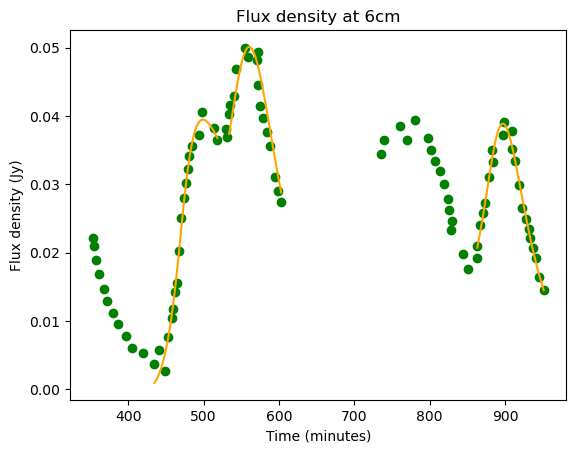

In [23]:
time=cm6['UT time (hours)'].to(u.s).value
FluxDens= cm6['Flux density (mJy)'].to(u.Jy).value
peaks= [[11,30], [30,48], [65,86]] 
plt.scatter(time/60 , FluxDens, c='green')

plt.xlabel(f"Time (minutes)")
plt.ylabel(f'Flux density (Jy)')
plt.title('Flux density at 6cm')

frequency= wavelenghttofreq(6*u.cm).to(u.Hz).value
cm6_fit=VanDerLaanFit(time, FluxDens, peaks, p, B0, 0, N0, speed, frequency, d, r0, 1.)
cm6_fit

Now we will make the mean of the values for each outburst and get a final valu with a std

In [24]:
def Outburststats(peaks_number, spectrum_fit):
    """
    Returns the mean and the standard deviation for each peak and paramenter promediating in all filters
    
    Parameters
    :peaks_number: number of peaks that are being consider, peaks must coincide for every wavelenght, and the fit 
    parameters must be same same too
    :spectrum: Array with the fit parameters for each wavelenght in each element of the array

    Output
    :mean: array of array containing the means, mean[0] is first peak
    :std: array of array containing the std
    """
    #Initialicing
    mean=[]
    std=[]
    parameter_number= len(spectrum_fit[0][0])
    #Loop over peaks
    for i in np.arange(0, peaks_number):
        alpha=np.zeros(parameter_number)
        beta=np.zeros(parameter_number)
        #Loop over fit parameter
        for j in np.arange(0, parameter_number):
            #Getting all wavelenghts on a single list se we can make mean and std
            aux=[]
            for spec in spectrum_fit:
                aux.append(spec[i][j])
            alpha[j]=np.mean(aux)
            beta[j] = np.std(aux)
        #Appending each peak as a list entry
        mean.append(alpha)
        std.append(beta)
    return (mean, std)

We can plot the relative std to the mean value and have a first idea of the fit.

In [25]:
data=Outburststats(len(peaks), ([cm2_fit, cm3_fit, cm6_fit]))
np.array(data[1])/np.array(data[0])

array([[ 0.25479128,  0.73050583,  0.61812028,  0.0934189 , -0.27127082],
       [ 0.08310046,  0.6800023 ,  1.31458793,  0.24046551, -0.37518071],
       [ 0.14990558,  0.29781071,  0.67590962,  0.12632366, -0.66235809]])

We can see that the results are quite consistent in each outburst but they are not in between outburst since: (I DONT KNOW WHY)

In [26]:
np.array(data[0])

array([[ 8.53944753e-01,  6.43982948e+01,  1.92523234e+07,
         2.05883162e+09, -4.75082935e+02],
       [ 3.29406043e+00,  1.13394368e+00,  2.20652592e+03,
         6.87944536e+08, -5.91964552e+03],
       [ 2.13571965e+00,  3.23045170e+00,  1.16511742e+05,
         1.04417533e+09, -2.95083028e+03]])

## 2.1 Multiple outburst fit.

For this, we will make a function that given 2 consecutive outburst and a set of parameters for these, computes the FluxAtT with those parameters and gives Flux - FluxAtT(). With leastsquare we will minimice this difference.

In [27]:
def leastsq_function(params, *args):
    """
    
    """
    #Params and args, if different are wanted to be fitted or to be fitted separately move from args to params or vice-versa
    p = params[0]
    B0 = params[1]
    N01= params[2]
    N02= params[3]
    speed= params[4]
    offset= [params[5], params[6]]
    
    time = args[0]
    FluxValue = args[1]
    frequency = args[2]
    distance = args[3]
    r0 = args[4]
    a= args[5]
    peaks = args[6]


    #Slicing the time and flux to only the 2 peaks
    time= time[peaks[0][0]:peaks[1][1]]
    time= time - min(time)
    FluxValue=FluxValue[peaks[0][0]:peaks[1][1]]


    #Splitting time zones so it is easier to define the fit
    time_split= (time[time < offset2], time[offset2 <= time])

    #Starting the vectors
    Fluxfit = np.empty(time.shape)
    Fluxfit1= np.empty(time_split[0].shape)
    Fluxfit2= np.empty(time_split[1].shape)

    #Computing the flux in the 2 zones
    Fluxfit1= FluxatT(time_split[0], frequency, p, B0, N01, distance, r0, speed, a, offset[0])
    Fluxfit2= (FluxatT(time_split[1], frequency, p, B0, N01, distance, r0, speed, a, offset[0]) +
                  FluxatT(time_split[1], frequency, p, B0, N02, distance, r0, speed, a, offset[1]))
    Fluxfit= np.concatenate((Fluxfit1, Fluxfit2), axis=0)
            
    return (FluxValue - Fluxfit)*0.001

In [53]:
time=cm2['UT time (hours)'].to(u.s).value
FluxDens= cm2['Flux density (mJy)'].to(u.Jy).value
peaks= [[5,27], [27,53]]
frequency= wavelenghttofreq(2*u.cm).to(u.Hz).value
offset1=200.
offset2=4100.

params0 = (p, B0, N0, N0, speed, offset1, offset2)
args = (time, FluxDens, frequency, d, r0, 1., peaks)
result = scipy.optimize.least_squares(leastsq_function, params0, args=args)

/tmp/ipykernel_42558/3936713244.py:46: RuntimeWarning: invalid value encountered in power
  v1=(2*c1*(s*Pacholcyzk6(p))**(2/(p+4))*N_0**(2/(p+4))*B**((p+2)/(p+4)))
/tmp/ipykernel_42558/789289804.py:16: RuntimeWarning: invalid value encountered in power
  EmissionCoeff=Pacholcyzk5(p)*N0*B**((p+1)/2)*(frequency/(2*c1))**((1-p)/2)
/tmp/ipykernel_42558/789289804.py:33: RuntimeWarning: invalid value encountered in power
  AbsorptionCoeff=Pacholcyzk6(p)*N0*B**((p+2)/2)*(frequency/(2*c1))**(-(p+4)/2)
/tmp/ipykernel_42558/1912815321.py:21: RuntimeWarning: overflow encountered in exp
  I=SourceFuncSynch(p, B, N0, frequency)*(1-np.exp(-SynchrotronAbsorptionCoeff(p, B, N0, frequency)*s))


Let's make a plot

In [54]:
#Slicing the time and flux to only the 2 peaks and normalicing
time_sl= time[peaks[0][0]:peaks[1][1]]
time_sl= time_sl - min(time_sl)
FluxDens_sl=FluxDens[peaks[0][0]:peaks[1][1]]

Text(0.0, 1.0, 'Multiple outburst simultaniusly fitted')

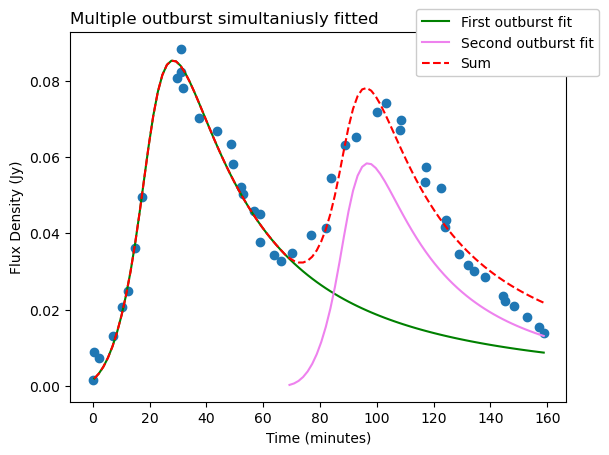

In [55]:
time=np.linspace(time_sl[0], time_sl[peaks[1][1]-peaks[0][0]-1], 100)
time1= time[time < offset2]
time2= time[offset2 <= time ]

yfit = np.empty(time.shape)
yfit1= np.empty(time1.shape)
yfit2= np.empty(time2.shape)

yfit1= FluxatT(time1, frequency, result['x'][0], result['x'][1], result['x'][2], d, r0, result['x'][4], 1., result['x'][5])
yfit2= (FluxatT(time2, frequency, result['x'][0], result['x'][1], result['x'][2], d, r0, result['x'][4], 1., result['x'][5]) +
              FluxatT(time2, frequency, result['x'][0], result['x'][1], result['x'][3], d, r0, result['x'][4], 1., result['x'][6]))
yfit= np.concatenate((yfit1, yfit2), axis=0)

#Some arrays for the plot
yfit2_withoutFlux2= FluxatT(time2, frequency, result['x'][0], result['x'][1], result['x'][2], d, r0, result['x'][4], 1., result['x'][5])
yfit2_withoutFlux1= FluxatT(time2, frequency, result['x'][0], result['x'][1], result['x'][3], d, r0, result['x'][4], 1., result['x'][6])


plt.scatter(time_sl/60, FluxDens_sl)
plt.plot(time/60, np.concatenate((yfit1, yfit2_withoutFlux2), axis=0), c='green', label='First outburst fit')
plt.plot(time2/60, yfit2_withoutFlux1, c='violet', label='Second outburst fit')
plt.plot(time/60, yfit, c='red', linestyle='dashed', label= 'Sum')

plt.ylabel("Flux Density (Jy)")
plt.xlabel("Time (minutes)")
plt.legend(loc='best',  bbox_to_anchor=(0, 0, 1.08, 1.08), framealpha= 1)
plt.title('Multiple outburst simultaniusly fitted', loc='left')

In [57]:
result['x']

array([ 8.77600298e-01,  4.29474503e+01,  1.36352600e+07,  7.47053466e+06,
        2.39780583e+09, -6.24090024e+01,  4.31525911e+03])

# 3. Alpha evolution with time

Now we will be focusing on the first outburst and fitting the flux density over frequency. We have 3 frequencies, and considering a power law
$$
    S= S_0 \left( \frac{\nu}{\nu_0} \right)^{\alpha},
$$
we can get the alpha describing the optically thin region. Later, we will make this fit for a number of times and plot how the slope of the optically thin region evolves with time. Since we do not have the original data, time values will not coincide for the 3 wavelenghts, we have to handle this first. We will make a function that for each point in the wavelenght with fewer points select the nearest point with higher time value and assuming they both occur at a promediated time. At the end we will have an array of arrays where each sub array contains the time in $[0]$ and the flux in each wavelenght in the rest of index.

In [32]:
def TimeFluxRedef(data):
    """
    Gives a list of array where each array have the time and flux densities for different wavelenghts. fFr each 
    point in the wavelenght with fewer points, select the nearest point with higher time value on the other wavelenghts
    and assumes they both occur at a promediated time.
    

    Parameters
    :data: List with the different data for each wavelength, must have ['UT time (hours)'] and ['Flux density (mJy)']

    Output
    :TimeFluxRedef: List of arrays with the time array[last] (s) and flux densities (Jy) for each wavelenght in first entries
    """
    #Finding the wavelenght with fewer points
    aux=[]
    TimeFluxRedef=[]
    for wavelenght in data:
        aux.append(len(wavelenght['UT time (hours)'].value))
    minimun= np.argmin(np.array(aux))

    
    #Associate each point in this wavelenght to one in the others
    #Loop over all times in the wavelenght with fewer points
    for points in data[minimun]:
        time= points['UT time (hours)'].to(u.s).value
        #Initialize the vector containing each point info, a flux for everywavelenght len(data) and one for time
        point= np.zeros(len(data))
        #Giving the first value
        point[minimun]= points['Flux density (mJy)'].to(u.Jy).value
        #New index range of data without the minimun so we have them in the same order that they entered
        NewRange= list(np.arange(0, len(data)))
        NewRange.pop(minimun)
        mean_time= time
        #Loop over the others wavelenghts to assign a value
        for i in NewRange:
            #Check the time in the other wavelenghts
            for points2 in data[i]:
                time2= points2['UT time (hours)'].to(u.s).value
                if time2 >= time:
                    point[i]= points2['Flux density (mJy)'].to(u.Jy).value
                    mean_time= mean_time+time2
                    break
        mean_time= mean_time/len(data)
        point= list(point)
        point.append(mean_time)
        TimeFluxRedef.append(point)
    return TimeFluxRedef

Now we can procced to get the slope $\alpha$ at each time.

In [33]:
def FluxDensFreqPL(freq, freq_0, Flux_0, alpha):
    """
   Returns the flux at a given frequencie considering a power law.

    Parameters
    :frequencie: frequencies at which flux will be computed
    :freq_0: Reference frequency
    :Flux_0: Reference flux at freq_0
    :alpha: power law exponent

    Outputs
    :FluxDens: Flux density at frequency
    """

    FluxDens= Flux_0*(freq/freq_0)**alpha
    return FluxDens

In [34]:
freq_array= [wavelenghttofreq(2*u.cm).value, wavelenghttofreq(3.6*u.cm).value, wavelenghttofreq(6*u.cm).value]
mean_freq= np.mean(freq_array)
fit= np.zeros(len(TimeFluxRedef([cm2, cm3, cm6])))
alpha= []
time= []
Fit_param=[]
for point in TimeFluxRedef([cm2, cm3, cm6]):
    fit= curve_fit(lambda freq, Flux_0, alpha: FluxDensFreqPL(freq, mean_freq, Flux_0, alpha),
                     freq_array, point[:-1], maxfev=5000)
    time.append(point[-1])
    alpha.append(fit[0][1])
    Fit_param.append(fit[0])
#Remove last point because it had issues
time.pop()
alpha.pop()

-1.2590980695405736

We can now plot the results and see how alpha evolves with time. We will plot it along the Spectrum plot to have an insight of the behaviour.

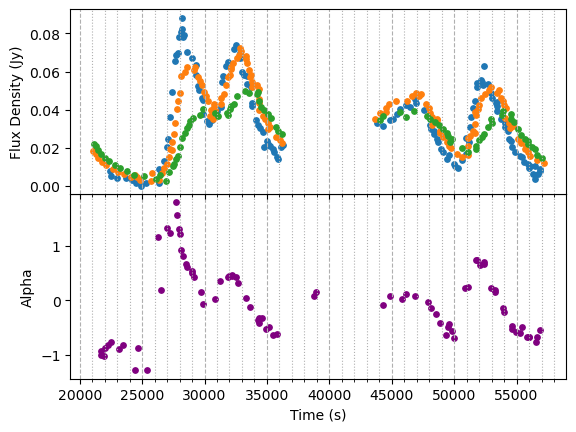

In [35]:
gs = grd.GridSpec(2, 1)
dot_size= 15


#Potting the alphas
ax= plt.subplot(gs[1])
ax.scatter(time, alpha, color='purple', s=dot_size)
ax.set(ylabel='Alpha',xlabel="Time (s)")

#Plotting the data
ax2= plt.subplot(gs[0], sharex= ax)
ax2.scatter(cm2['UT time (hours)'].to(u.s).value, cm2['Flux density (mJy)'].to(u.Jy).value, s=dot_size)
ax2.scatter(cm3['UT time (hours)'].to(u.s).value, cm3['Flux density (mJy)'].to(u.Jy).value, s=dot_size)
ax2.scatter(cm6['UT time (hours)'].to(u.s).value, cm6['Flux density (mJy)'].to(u.Jy).value, s=dot_size)
ax2.set(ylabel="Flux Density (Jy)")

ax.xaxis.set_major_locator(MultipleLocator(5000))
ax2.xaxis.set_major_locator(MultipleLocator(5000))

# Change minor ticks to show every 1000. (5000/5 = 1000)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))

#Merge axis and hide upper x axis
plt.subplots_adjust(hspace= 0.0)
plt.setp(ax2.get_xticklabels(), visible= False)

ax.grid(axis='x', which='minor', linestyle=':')
ax.grid(axis='x', which='major', linestyle='--')

ax2.grid(axis='x', which='minor', linestyle=':')
ax2.grid(axis='x', which='major', linestyle='--')

Let's try to plot the spectrum and frequencies for the first spectrum with a progressive color indicating the time

Text(0.5, 0, 'Frequency (Hz)')

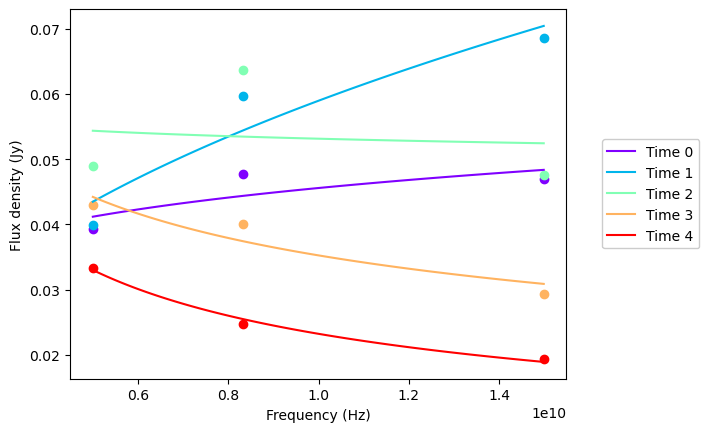

In [36]:
#We know the minimun of points is cm6 so the peaks will be described by it's peaks= [[11,30], [30,48], [65,86]] 
#Select outburst number
it=1
data=TimeFluxRedef([cm2, cm3, cm6])[peaks[it][0]:peaks[it][1]]
data.pop()
data.pop()
cov_matrix=[]
Fit_param= []

#Select one every 5 points
#data_short= data[0::6]

#Select only a few points
n=4 #Promediate each n points
data_short=[]
for i in np.arange(1, int(len(data)/n)):
    aux= np.median(data[(i-1)*n:i*n], axis= 0)
    data_short.append(aux)

#Latter points are red, first points blue
colors = plt.cm.rainbow(list(np.linspace(0, 1, len(data_short))))
#Indexing the colors
i=0
for point, c in zip(data_short, colors):
    plt.scatter(freq_array, point[:-1], color=c)
    fit= curve_fit(lambda freq, Flux_0, alpha: FluxDensFreqPL(freq, mean_freq, Flux_0, alpha),
                     freq_array, point[:-1], maxfev=5000)
    cov_matrix.append(fit[1])
    Fit_param.append(fit[0])
    freqcont= np.linspace(min(freq_array), max(freq_array), 100)
    plt.plot(freqcont , fit[0][0]*(freqcont/mean_freq)**(fit[0][1]), color=c, label=f'Time {i}')
    i=i+1
    
plt.legend(loc='center',  bbox_to_anchor=[1.17, 0.5], framealpha= 1)
plt.ylabel('Flux density (Jy)')
plt.xlabel('Frequency (Hz)')

We can now make an estimation of the uncertainties of our fit when computing fluxes. For that we will get $\alpha$ and $S_0$ uncertainties and run a number of iteration of the model with values of the parameters inside that range. For each point we have a covariance matrix, it's diagonal are the uncertainties.

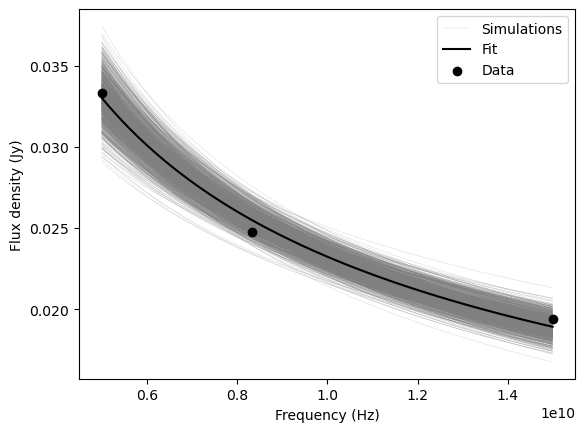

In [37]:
i=4 #Number of the time at which the uncertainties will be computed

#Plot the uncertainties
n_sim= 1000 #Number of simulations for the uncertainties

variances=[]
#Initialicing the variances array
for j in np.arange(0, len(Fit_param[i])):
    a=[]
    variances.append(a)
#initialicing the new param array
Fit_param_new= np.array(Fit_param).copy()
for simulation in np.arange(0, n_sim):
    for j in np.arange(0, len(Fit_param[i])):
        Fit_param_new[i][j]= Fit_param[i][j]
        variance=np.random.normal(0, np.sqrt(cov_matrix[i].diagonal()[j]))
        Fit_param_new[i][j] = Fit_param_new[i][j] + variance
        variances[j].append(variance)      
    plt.plot(freqcont , Fit_param_new[i][0]*(freqcont/mean_freq)**(Fit_param_new[i][1]), c='gray', linewidth=0.1)
#Plot the last one again to get the label
plt.plot(freqcont , Fit_param_new[i][0]*(freqcont/mean_freq)**(Fit_param_new[i][1]), c='gray', linewidth=0.1, label='Simulations')

#plot the fit
plt.plot(freqcont , Fit_param[i][0]*(freqcont/mean_freq)**(Fit_param[i][1]), c='black', label='Fit')
plt.scatter(freq_array, data_short[i][:-1], c='black', zorder=8, label='Data')


plt.ylabel('Flux density (Jy)')
plt.xlabel('Frequency (Hz)')
plt.legend()

We can also compute the confidence interval of a sample.

In [38]:
def calc_ci(optimal_param, cov_matrix, data, func, N=10000):
    """
    Returns the confidence interval of a function in each data point (Ive seen different expressions wich % is this??)

    Parameters
    :optimal_param: Optimal parameters that fit the data to the function
    :cov_matrix: Covariance matrix of the fit
    :data: Data set in which the function will be evaluated
    :func: Function that has been fitted
    :N: Number of random points used to calculate the confidence interval

    Output
    :upper_bound: Upper bound for the confidence interval, array where each entry is one data point
    :lower_bound:  Lower bound for the confidence interval, array where each entry is one data point
    :y_err: Half height of the coinfinence interval
    """
    #Get the uncertainties of the parameters given a covariance matrix
    optimal_param_err = np.sqrt(np.diagonal(cov_matrix))
    #Initialice the new parameters sampled as a normal
    params_normal = np.empty((len(optimal_param), N))

    #Normal distribution around optimal parameters
    for i, (p, p_err) in enumerate(zip(optimal_param, optimal_param_err)):
        params_normal[i] = np.random.normal(p, p_err, N)

    #Initialicing the bound for the function
    y_err = np.empty_like(data)
    upper_bound = np.empty_like(data)
    lower_bound = np.empty_like(data)

    #Computing the coinfinence interval
    for i, point in enumerate(data):
        #Standart deviation of the function evaluated on the normal distribution of the params as the error
        y_err[i] = np.std(func(point, *params_normal))
        upper_bound[i] = func(point, *optimal_param) + y_err[i]
        lower_bound[i] = func(point, *optimal_param) - y_err[i]
        
    return lower_bound, upper_bound, y_err[i]

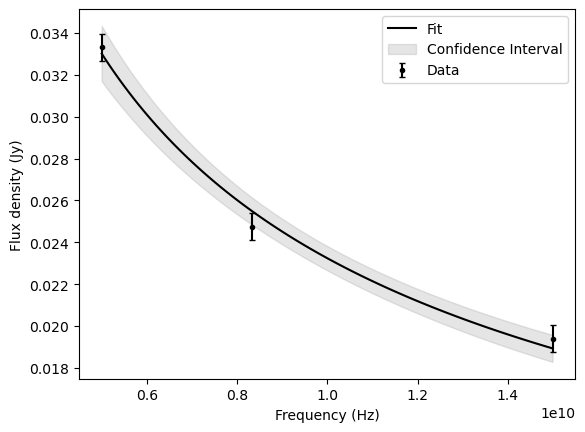

In [39]:
i=4
confidence_i = calc_ci(Fit_param[i], cov_matrix[i], freqcont, 
        lambda freq, Flux_0, alpha : FluxDensFreqPL(freq, mean_freq, Flux_0, alpha))

#Plot the fit
plt.plot(freqcont , FluxDensFreqPL(freqcont, mean_freq, Fit_param[i][0], Fit_param[i][1]), c='black', label='Fit')
plt.errorbar(freq_array, data_short[i][:-1], yerr= confidence_i[2],fmt= '.',capsize= 2 , c='black', zorder=8, label='Data')

#Plot the interval
y=  FluxDensFreqPL(freqcont, mean_freq, Fit_param[i][0], Fit_param[i][1])
l_b= confidence_i[0]
u_b = confidence_i[1]
plt.fill_between(freqcont, (l_b), (u_b), alpha=.2, label= 'Confidence Interval', color= 'grey')

plt.ylabel('Flux density (Jy)')
plt.xlabel('Frequency (Hz)')
plt.legend()